In [58]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import urllib.request

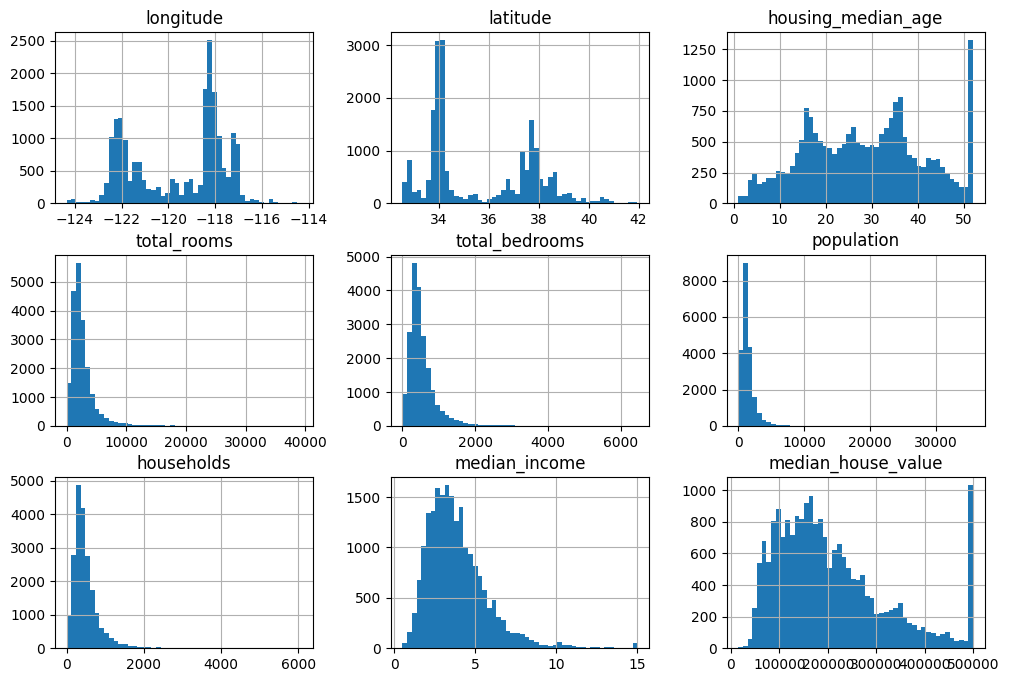

In [59]:
# Data Visualization
housing.hist(bins=50, figsize=(12, 8))
plt.show()

In [50]:
# Fetching and Loading Data
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [41]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [42]:
# Get Random Test Data Manually (0.2 == 20%) 
def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = shuffle_and_split_data(housing, 0.2) 

In [43]:
# Another Implementation of getting Data with 1:5 Ratio (test_set:data)

from zlib import crc32

# Function to check if an identifier belongs to the test set
def is_id_in_test_set(identifier, test_ratio):
    # Hash the identifier using crc32 and check if it's below the test_ratio threshold
    return crc32(np.int64(identifier)) < test_ratio * 2**32

# Function to split data into training and test sets based on hashed IDs
def split_data_with_id_hash(data, test_ratio, id_column):
    # Extract the column containing unique IDs
    ids = data[id_column]
    # Apply the is_id_in_test_set function to each ID
    # Returns True for test set rows, False for training set rows
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    # Use Boolean indexing to split the data into training and test sets
    return data.loc[~in_test_set], data.loc[in_test_set]

# Reset index to create a unique identifier for each row in the dataset
housing_with_id = housing.reset_index()

# Split the dataset into 80% training and 20% test sets using the index as the ID column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, id_column="index")


In [51]:
# Split data (20%:80%) Using ScikitLearn

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

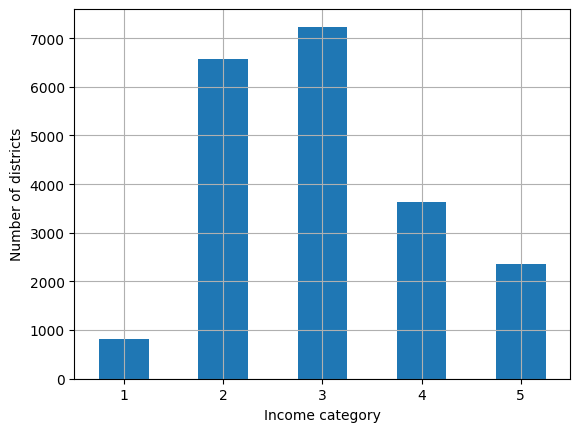

In [52]:
# Represent Various Categories of Incomes (Stratified Sampling)

housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1, 2, 3, 4, 5])

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [53]:
# Stratified Sampling

from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [54]:
strat_train_set, strat_test_set = strat_splits[0]

In [55]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [56]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [57]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)